In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from draperqftadder_adapt import adder_mod
from qiskit.circuit.library import QFT

def ctrl_mult_mod(n_bits, a, N):
    """Retorna um circuito que implementa o Multiplicador Modular proposto no artigo [1],
       com 2 operandos clássicamente calculados (a e N).
       
       Utiliza o Adder Modular 
       https://github.com/kourggos/my-qiskit-circuits/blob/e261229ef1699ea813e49bc70432219047aa2ea3/draperqftadder_adapt.py

    Faz a operação a * b mod N : b é o número que está no registrador reg_b

    Exemplo de Multiplicador Modular com um operando de 4 bits
    
              ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐
   c: ────────┤0             ├┤0             ├┤0             ├┤0             ├─────────
              │              ││              ││              ││              │
 b_0: ────────┤1             ├┤              ├┤              ├┤              ├─────────
              │              ││              ││              ││              │
 b_1: ────────┤              ├┤1             ├┤              ├┤              ├─────────
              │              ││              ││              ││              │
 b_2: ────────┤              ├┤              ├┤1             ├┤              ├─────────
              │              ││              ││              ││              │
 b_3: ────────┤              ├┤              ├┤              ├┤1             ├─────────
      ┌──────┐│              ││              ││              ││              │┌───────┐
 0_0: ┤0     ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤2 c_adder_mod ├┤0      ├
      │      ││              ││              ││              ││              ││       │
 0_1: ┤1     ├┤3             ├┤3             ├┤3             ├┤3             ├┤1      ├
      │      ││              ││              ││              ││              ││       │
 0_2: ┤2 QFT ├┤4             ├┤4             ├┤4             ├┤4             ├┤2 IQFT ├
      │      ││              ││              ││              ││              ││       │
 0_3: ┤3     ├┤5             ├┤5             ├┤5             ├┤5             ├┤3      ├
      │      ││              ││              ││              ││              ││       │
 0_4: ┤4     ├┤6             ├┤6             ├┤6             ├┤6             ├┤4      ├
      └──────┘│              ││              ││              ││              │└───────┘
help: ────────┤7             ├┤7             ├┤7             ├┤7             ├─────────
              └──────────────┘└──────────────┘└──────────────┘└──────────────┘

    Parametros:
    n_bits : int
        Número de bits do operando.
    a : int
        Operando implícito calculado classicamente.
    N : int
        Operando implícito que controla o mod

    Retorna:
    QuantumCircuit 
    circuito montado com os registradores nessa ordem:
        2n + 3 qubits
        registrador_controle (1 bit)
        registrador_operando (n_bits)
        registrador_ancilla (n_bits + 2)

    References: 
        [1] Vlatko Vedral, Adriano Barenco, and Artur Ekert, Quantum networks for elementary arithmetic operations, quant-ph/9511018
    """    

    reg_control = QuantumRegister(1, "c")
    
    reg_b = QuantumRegister(n_bits, "b")

    reg_0 = QuantumRegister(n_bits + 1, "0")

    reg_help = QuantumRegister(1, "help")

    qc = QuantumCircuit(reg_control, reg_b, reg_0, reg_help, name="mult_mod")

    qc.append(QFT(n_bits + 1, do_swaps=False), reg_0)

    for i in range(n_bits):

        qc.append(adder_mod(n_bits, ((2**i) * a) % N, N, controlado=True, control_number=2), reg_control[:] + reg_b[i:i+1] + reg_0[:] + reg_help[:])

    qc.append(QFT(n_bits + 1, do_swaps=False).inverse(), reg_0)

    return qc

In [9]:
n_bits = 8 # 2^n_bits = tamanho da amostra
r = 30 # o resultado à ser simulado

a = 1 

reg_c = QuantumRegister(1, "c")

reg_b = QuantumRegister(n_bits, "b")

reg_0 = QuantumRegister(n_bits + 1, "0")
    
reg_anc = QuantumRegister(1, "anc")

reg_result = ClassicalRegister(n_bits, "resultado")

qc = QuantumCircuit(reg_c, reg_b, reg_0, reg_anc, reg_result)

qc.x(reg_c[0])
qc.h(reg_b)

qc.append(ctrl_mult_mod(n_bits, a, r), reg_c[:] + reg_b[:] + reg_0[:] + reg_anc[:])

qc.append(QFT(n_bits, inverse=True), reg_b)

qc.measure(reg_b, reg_result)

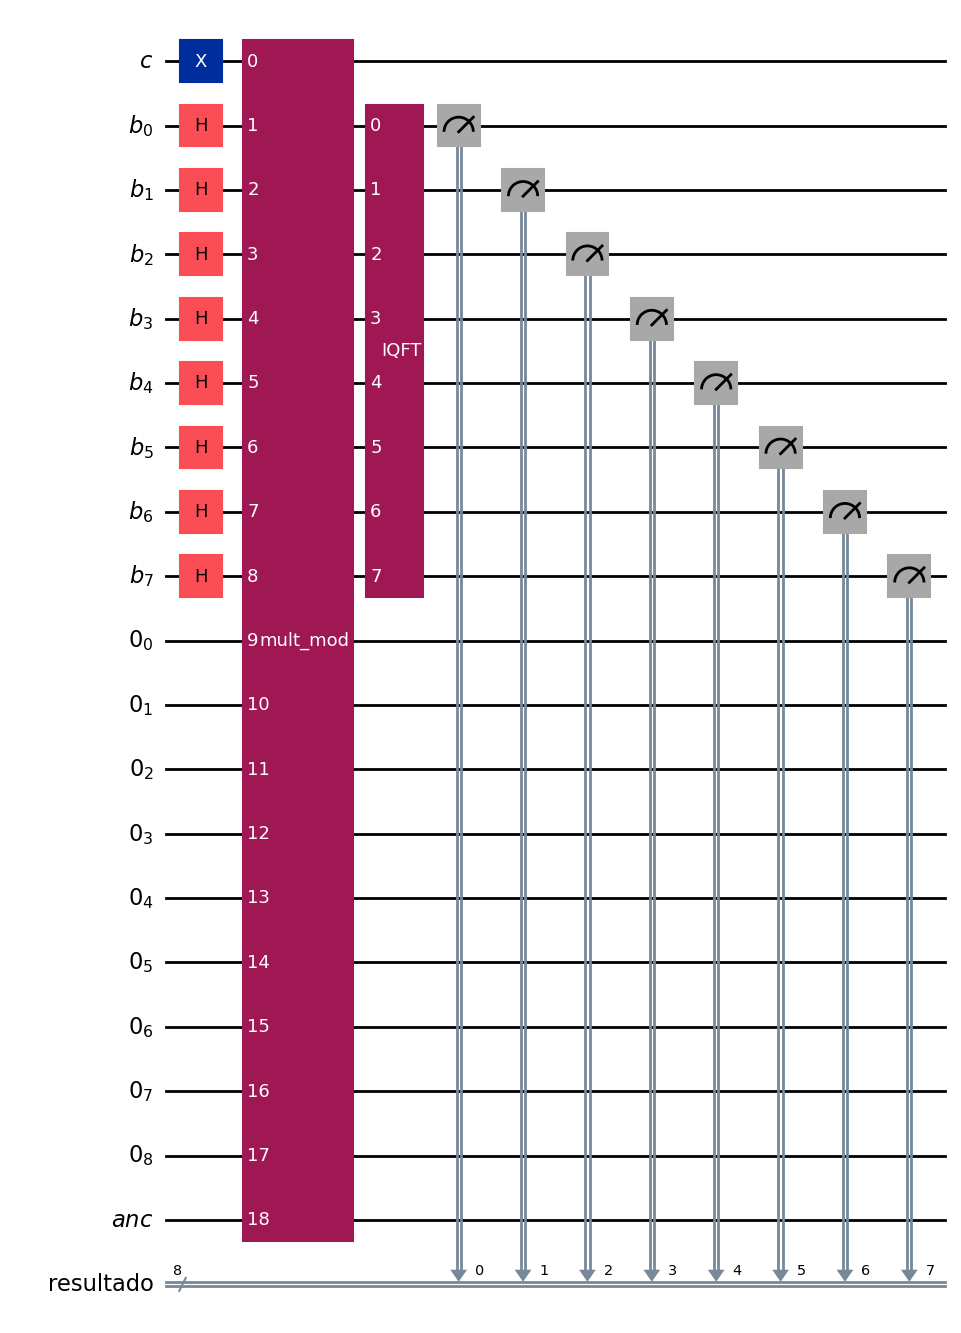

In [10]:
qc.draw("mpl")

In [11]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=2**14)
print(job.result()[0].data.resultado.get_int_counts())

Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(n_bits)):
  if i not in Resultado:
    Resultado[i] = 1

{230: 284, 248: 203, 9: 252, 137: 255, 222: 520, 77: 501, 196: 426, 213: 361, 68: 433, 187: 53, 188: 410, 34: 528, 111: 555, 95: 6, 120: 205, 119: 249, 145: 562, 239: 571, 205: 507, 85: 369, 179: 449, 17: 525, 226: 6, 51: 527, 162: 536, 176: 5, 0: 551, 60: 426, 84: 21, 135: 36, 25: 143, 224: 7, 10: 32, 138: 27, 43: 383, 102: 304, 247: 245, 169: 18, 136: 185, 153: 120, 31: 3, 128: 583, 94: 541, 154: 303, 231: 147, 26: 309, 171: 373, 161: 8, 214: 82, 103: 127, 104: 21, 117: 12, 229: 27, 8: 177, 27: 28, 6: 13, 173: 11, 245: 9, 163: 19, 93: 17, 237: 4, 170: 88, 79: 5, 59: 55, 215: 16, 197: 66, 86: 85, 152: 23, 88: 7, 203: 7, 42: 76, 133: 2, 204: 26, 101: 20, 78: 12, 208: 5, 45: 10, 50: 18, 99: 10, 66: 4, 198: 11, 186: 7, 123: 4, 38: 5, 194: 4, 61: 13, 41: 14, 192: 6, 189: 20, 249: 14, 150: 5, 57: 6, 69: 56, 81: 4, 52: 36, 155: 26, 76: 29, 87: 11, 174: 9, 118: 31, 67: 22, 47: 5, 16: 7, 11: 7, 112: 6, 178: 15, 191: 7, 29: 8, 21: 2, 24: 26, 32: 4, 217: 9, 7: 17, 64: 3, 241: 2, 253: 6, 206: 12

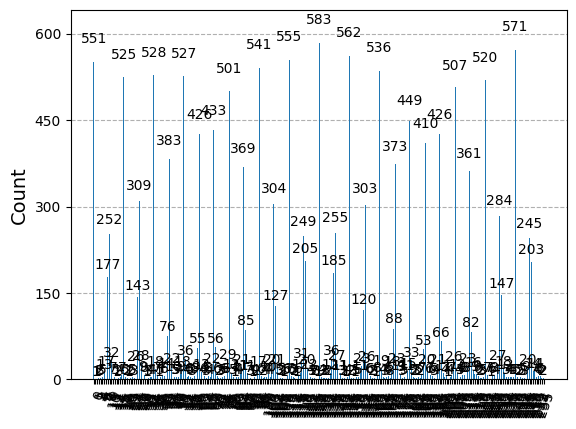

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)